In [2]:
EPSG_CODE = 2180

In [3]:
# https://pl.wikipedia.org/wiki/Układ_współrzędnych_2000
def convert_to_latlon(xllcenter, yllcenter, epsg_code = EPSG_CODE):
    import pyproj

    # Define the projection using the EPSG code
    projection = pyproj.Proj(init=f'epsg:{epsg_code}')

    # Calculate the latitude and longitude of the lower-left corner
    lon, lat = projection(xllcenter, yllcenter, inverse=True)

    return lat, lon

# Example usage
xllcenter = 495501.00  # Replace with your xllcenter value
yllcenter = 211497.00  # Replace with your yllcenter value
cell_size = 1  # Replace with your cell size value
rows = 1600  # Replace with the number of rows in your DEM
cols = 1000  # Replace with the number of columns in your DEM
epsg_code = 2180  # Replace with the EPSG code of your spatial reference system

lat, lon = convert_to_latlon(xllcenter, yllcenter, epsg_code)
print(f"Latitude: {lat}, Longitude: {lon}")
# PL-EVRF2007-NH


Latitude: 49.77081824397273, Longitude: 18.937501363154265


/home/istrzalka/miniconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
def add_to_lattitude(lat, lon, dy, dx):
    r_earth = 6378137
    from math import pi, cos

    new_lat = lat + (dy / r_earth) * (180 / pi)
    new_lon = lon + (dx / r_earth) * (180 / pi) / cos(lat * pi/180)

    return new_lat, new_lon

add_to_lattitude(lat, lon, 1000, 1600)

(49.77980139681392, 18.959755942069023)

In [5]:
import os
from math import floor
import regex as re

def get_data(file_name):
    print(file_name)
    with open(file_name, 'r') as input:    
        lines = input.readlines()
        lines = [line.strip() for line in lines]

        data = lines[6:]
        data = [re.split('\s+', line) for line in data]
        # for i in range(len(data)):
        #     for j in range(len(data[i])):
        #         if data[i][j] == '':
        #             print(i, j)
        data = [[float(x) for x in line] for line in data]

        return data

def database_covers():
    ret = []

    for file_name in os.listdir('map_data'):
        if file_name.endswith('.asc'):
            with open('map_data/' + file_name, 'r') as input:
                lines = input.readlines()
                lines = [line.strip() for line in lines]
                ncols = int(lines[0].split(' ')[-1])
                nrows = int(lines[1].split(' ')[-1])
                xllcenter = int(floor(float(lines[2].split(' ')[-1])))
                yllcenter = int(floor(float(lines[3].split(' ')[-1])))

                ret.append(((xllcenter, yllcenter), (xllcenter + ncols - 1, yllcenter + nrows - 1), 'map_data/' + file_name))
    
    return ret

dataset = database_covers()

In [6]:
print([(a, b) for a, b, _ in dataset])

[((651682, 176556), (654010, 178934)), ((640423, 173938), (642747, 176311)), ((667315, 183965), (669646, 186349)), ((705572, 189911), (707918, 192311)), ((700969, 192058), (703312, 194456)), ((656143, 178999), (658472, 181378)), ((682906, 191419), (685242, 193810)), ((696621, 187262), (698964, 189658)), ((660669, 179131), (662999, 181512)), ((642748, 171682), (645074, 174055)), ((676208, 188881), (678542, 191268)), ((701055, 189742), (703399, 192141)), ((669359, 190980), (671689, 193365)), ((719684, 176551), (722041, 178957)), ((694361, 187181), (696703, 189576)), ((708008, 185367), (710357, 187768)), ((669575, 184035), (671908, 186420)), ((703400, 187512), (705746, 189910)), ((682984, 189104), (685321, 191495)), ((644952, 174056), (647278, 176431)), ((660600, 181446), (662930, 183827)), ((642687, 173997), (645012, 176371)), ((708096, 183052), (710446, 185453)), ((673875, 191123), (676207, 193510)), ((678543, 186639), (680878, 189028)), ((653880, 178935), (656208, 181313)), ((680649, 1

In [7]:
def convert_to_xll_yll(lat, lon, epsg_code = EPSG_CODE):
    import pyproj

    # Define the projection using the EPSG code
    projection = pyproj.Proj(f'epsg:{epsg_code}')

    # Calculate the latitude and longitude of the lower-left corner
    xllcenter, yllcenter = projection(lon, lat)

    return xllcenter, yllcenter

x, y = convert_to_xll_yll(52.2446340, 21.1843740)
x, y = int(round(x, 1)), int(round(y, 1))
print(x, y) 

649085 488757


In [8]:
cur_node = ((0, 0), (0, 0), [])

In [9]:
def find_new_node(x, y):
    for node in dataset:
        (x1, y1), (x2, y2), _ = node
        if x1 <= x <= x2 and y1 <= y <= y2:
            data = get_data(node[2])
            return ((x1, y1), (x2, y2), data)
    print('Not found', convert_to_latlon(x, y))
    return None

def find_cell(x, y):
    global cur_node
    if cur_node == None:
        cur_node = find_new_node(x, y)
    (x1, y1), (x2, y2), data = cur_node
    if x1 <= x <= x2 and y1 <= y <= y2:
        return data[y2 - y][x - x1]
    else:
        cur_node = find_new_node(x, y)
        (x1, _), (_, y2), data = cur_node
        return data[y2 - y][x - x1]

def test(lat, lon):
    x, y = convert_to_xll_yll(lat, lon)
    x, y = int(round(x, 1)), int(round(y, 1))
    return find_cell(x, y)

In [10]:
test(49.4958, 21.9060)

map_data/76591_1244692_M-34-92-D-b-1-1.asc


392.75

In [11]:
def process_gpx_to_df(file_name):
    import gpxpy
    gpx = gpxpy.parse(open(file_name)) 
    
    # Make DataFrame
    track = gpx.tracks[0]
    segment = track.segments[0]
    
    points = []
    for track in gpx.tracks:
        for segment in track.segments: 
            for point in segment.points:
                points.append(((point.longitude, point.latitude), point.elevation))
    
    return points

In [12]:
gpx = process_gpx_to_df('gpx_data/lemko.gpx')

In [13]:
len(gpx)

34874

In [14]:
import numpy as np

In [15]:
elevation_gpx = np.array([ele for _, ele in gpx])
elevation_map = np.array([test(y, x) for (x, y), _ in gpx])

map_data/4468_249589_M-34-90-D-b-4-3.asc
map_data/4468_249590_M-34-90-D-b-4-4.asc
map_data/4468_249608_M-34-90-D-d-2-2.asc
map_data/4468_249590_M-34-90-D-b-4-4.asc
map_data/67500_795772_M-34-91-C-a-3-3.asc
map_data/67500_795770_M-34-91-C-a-3-1.asc
map_data/67500_795771_M-34-91-C-a-3-2.asc
map_data/67500_795765_M-34-91-C-a-1-4.asc
map_data/67500_795768_M-34-91-C-a-2-3.asc
map_data/67500_795774_M-34-91-C-a-4-1.asc
map_data/67500_795768_M-34-91-C-a-2-3.asc
map_data/67500_795769_M-34-91-C-a-2-4.asc
map_data/67500_795775_M-34-91-C-a-4-2.asc
map_data/67500_795769_M-34-91-C-a-2-4.asc
map_data/67500_795780_M-34-91-C-b-1-3.asc
map_data/67500_795781_M-34-91-C-b-1-4.asc
map_data/67500_795784_M-34-91-C-b-2-3.asc
map_data/67500_795785_M-34-91-C-b-2-4.asc
map_data/67500_795783_M-34-91-C-b-2-2.asc
map_data/67500_795799_M-34-91-D-a-1-1.asc
map_data/67500_795749_M-34-91-B-c-3-3.asc
map_data/67500_795750_M-34-91-B-c-3-4.asc
map_data/67500_795800_M-34-91-D-a-1-2.asc
map_data/67500_795750_M-34-91-B-c-3-4.

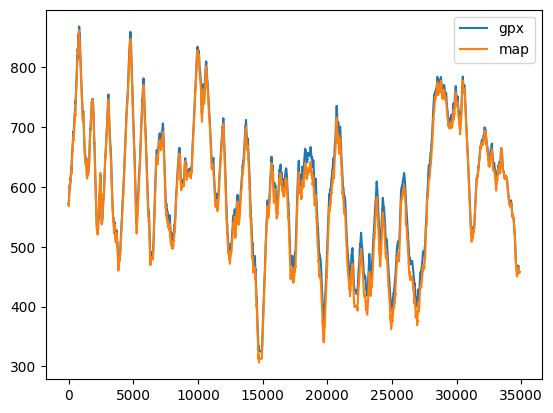

In [16]:
# try to fill missing values with average of positive values to the left and right
for i in range(len(elevation_map)):
    if elevation_map[i] < 0:
        left_i = i - 1
        while left_i >= 0 and elevation_map[left_i] < 0:
            left_i -= 1
        right_i = i + 1
        while right_i < len(elevation_map) and elevation_map[right_i] < 0:
            right_i += 1
        elevation_map[i] = (elevation_map[left_i] + elevation_map[right_i]) / 2


import matplotlib.pyplot as plt
import numpy as np

plt.plot(elevation_gpx, label='gpx')
plt.plot(elevation_map, label='map')
plt.legend()
plt.show()

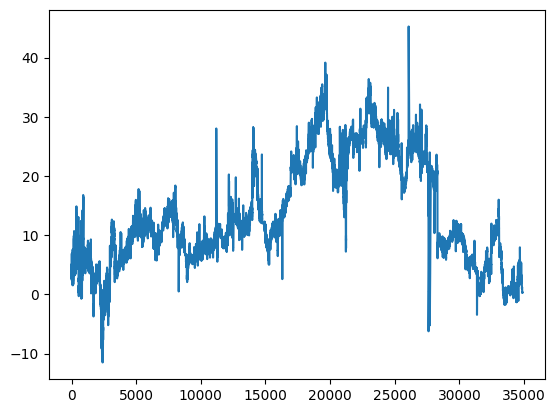

In [17]:
# calculate difference
diff = elevation_gpx - elevation_map
plt.plot(diff)
plt.show()

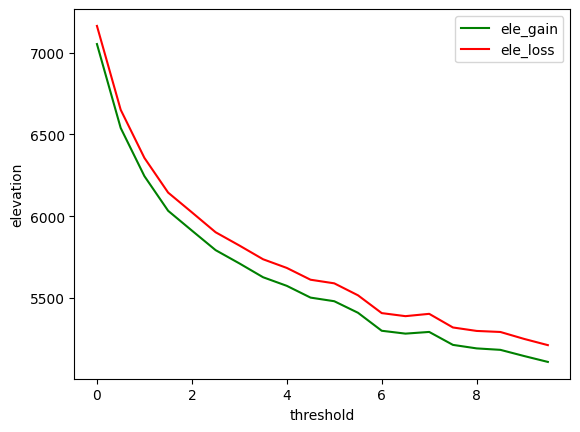

+-----------+----------+----------+
| threshold | ele_gain | ele_loss |
+-----------+----------+----------+
|    0.0    | 7052.84  |  7163.7  |
|    0.5    | 6539.85  |  6651.1  |
|    1.0    | 6245.14  | 6356.68  |
|    1.5    | 6033.16  | 6144.41  |
|    2.0    |  5912.3  | 6023.84  |
|    2.5    | 5792.65  | 5902.02  |
|    3.0    | 5711.67  | 5821.04  |
|    3.5    | 5626.94  | 5736.89  |
|    4.0    | 5574.31  | 5683.82  |
|    4.5    | 5502.37  | 5611.74  |
|    5.0    | 5480.26  | 5589.63  |
|    5.5    |  5409.6  | 5516.39  |
|    6.0    | 5299.61  |  5407.6  |
|    6.5    | 5282.15  | 5388.94  |
|    7.0    | 5292.47  | 5403.13  |
|    7.5    | 5213.29  | 5319.77  |
|    8.0    |  5191.8  |  5298.6  |
|    8.5    | 5182.93  |  5292.2  |
|    9.0    | 5145.11  |  5249.8  |
|    9.5    | 5109.11  | 5211.74  |
+-----------+----------+----------+


In [18]:
MAX_THRESHOLD = 10
STEP = 0.5

def plot_diff():
    ele_gain, ele_loss = [], []
    for i in np.arange(0, MAX_THRESHOLD, STEP):
        last_ele = elevation_gpx[0]
        temp = 0
        gain, loss = 0, 0
        for ele in elevation_gpx[1:]:
            temp += ele - last_ele
            if temp > i:
                gain += temp
                temp = 0
            elif temp < -i:
                loss += temp
                temp = 0
            last_ele = ele
        ele_gain.append(gain)
        ele_loss.append(-loss)

    plt.xlabel('threshold')
    plt.ylabel('elevation')
    plt.plot(np.arange(0, MAX_THRESHOLD, STEP), ele_gain, label='ele_gain', color='green')
    plt.plot(np.arange(0, MAX_THRESHOLD, STEP), ele_loss, label='ele_loss', color='red')
    plt.legend()
    plt.show()

    import prettytable

    table = prettytable.PrettyTable()
    table.field_names = ['threshold', 'ele_gain', 'ele_loss']
    for i in range(len(ele_gain)):
        table.add_row([i * STEP, round(ele_gain[i], 2), round(ele_loss[i], 2)])
    print(table)


plot_diff()

In [19]:
v = data[0][2]

# plot the data
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(v, cmap='gist_earth', interpolation='nearest')
plt.show()

NameError: name 'data' is not defined